In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import feather
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings("ignore")

# Feature Selection
The next step is to decide which attributes in our dataset are most relevant for predicting the tip level. 

In [3]:
clustered_df = feather.read_dataframe('Datasets/5clusters.feather')
clustered_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,...,year,hour,day,month,period,condition,trip_duration,weekday,cluster,tip_level
0,2014-12-10 08:46:36,2014-12-10 08:57:19,1,1.30,-73.983960,40.743340,-73.974555,40.756048,8.5,0.0,...,2014,8,10,12,M,Cloudy,10.716667,Wednesday,3,3
1,2014-12-10 09:16:56,2014-12-10 09:25:49,1,1.10,-73.998376,40.719674,-74.010260,40.720438,7.5,0.0,...,2014,9,10,12,M,Cloudy,8.883333,Wednesday,0,2
2,2014-12-10 10:55:00,2014-12-10 11:22:00,1,1.68,-73.990410,40.731270,-73.996068,40.748425,16.0,0.0,...,2014,10,10,12,M,Cloudy,27.000000,Wednesday,0,3
3,2014-12-10 10:36:27,2014-12-10 10:54:07,1,1.20,-73.984772,40.747895,-73.998100,40.756175,11.5,0.0,...,2014,10,10,12,M,Cloudy,17.666667,Wednesday,3,2
4,2014-12-10 11:31:25,2014-12-10 11:37:53,1,1.00,-73.967168,40.793447,-73.978950,40.784788,6.0,0.0,...,2014,11,10,12,M,Cloudy,6.466667,Wednesday,1,1


### Numeric variables

In [5]:
pu_coords = ['pickup_latitude', 'pickup_longitude']
do_coords = ['dropoff_latitude', 'dropoff_longitude']

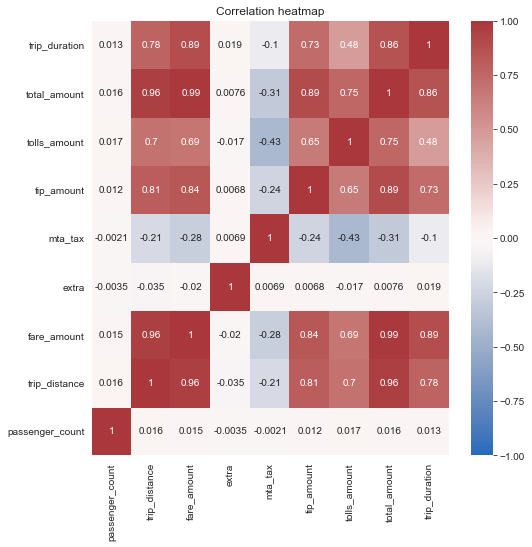

In [25]:
plt.figure(figsize=(8,8))

time_cols = ['hour', 'month', 'year', 'day']
drops = pu_coords+do_coords+time_cols+['cluster']

ax = sns.heatmap(clustered_df.drop(drops,axis=1).corr(),
 vmax=1, vmin=-1, cmap=sns.color_palette("vlag", as_cmap=True), annot=True);
ax.invert_yaxis()
ax.set_title("Correlation heatmap")
plt.show()

From the correlation heatmap, we can already predict that the fare amount, trip distance, and trip duration will have significant effect on the tip amount level even though this plot is only showing the correlation with the actual tip value. It is also worthwhile to note that since the total amount is calculated from the tip amount, it will not make sense to include this attribute in our model even though it has the highest correlation.

In [12]:
col_names = ['Tip level', 'Mean trip distance', 'Mean trip duration', 
             'Mean fare amount', 'Mean total amount', 'Mean tolls amount']
gp_num = clustered_df.groupby('tip_level')\
['trip_distance', 'trip_duration', 'fare_amount', 'total_amount', 'tolls_amount'].mean().reset_index()
gp_num.columns = col_names
gp_num

,Tip level,Mean trip distance,Mean trip duration,Mean fare amount,Mean total amount,Mean tolls amount
0,1,1.386501,8.268132,7.729359,9.592314,0.054479
1,2,1.852754,12.126825,9.985481,12.917318,0.011508
2,3,6.646524,27.348494,24.920074,32.841147,1.433736


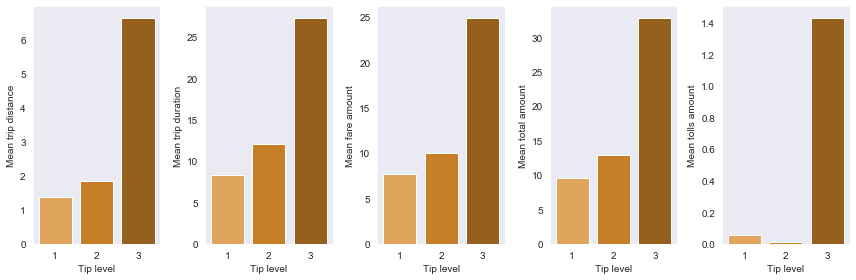

In [15]:
c = ['#e0a55c', '#c67f26', '#955f1d']

sns.set_style("dark")
plt.figure(figsize=(12,4))
i = 1
for j in gp_num.columns[1:]:
    plt.subplot(1,5,i)
    bar = plt.bar(gp_num['Tip level'], gp_num[j], color=c) 
    plt.ylabel(gp_num.columns[i])
    plt.xlabel("Tip level")
    i+=1

plt.tight_layout()
plt.show()

Once again, we can clearly see there’s a relationship between the trip distance, trip duration, fare amount and the tip level. Typically, the higher these are, the higher the tip level is. The mean tolls amount however seems to be quite similar for low and medium tips.

### Categorical variables

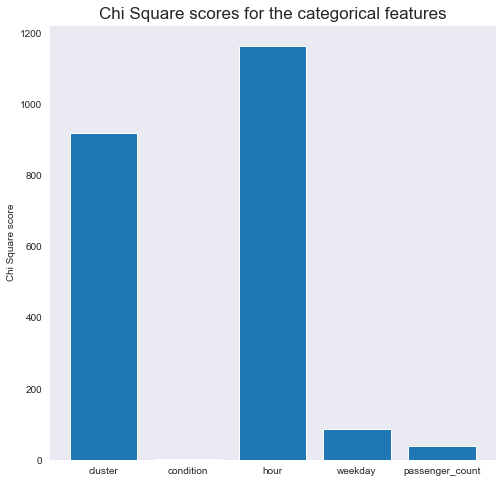

In [26]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

col_names = ['cluster', 'condition', 'hour', 'weekday', 'passenger_count']
X_train, X_test, y_train, y_test = train_test_split(clustered_df[col_names],
                                                    clustered_df['tip_level'], test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
# for i in range(len(fs.scores_)):
#     print(f"{col_names[i]}: {fs.scores_[i]}")

sns.set_style("dark")
plt.figure(figsize=(8,8))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(range(len(col_names)), col_names)
plt.ylabel('Chi Square score')
plt.title("Chi Square scores for the categorical features", fontsize=17)
plt.show()

* According to this, it would be best to choose 2 features which are cluster and hour. 
* It seems the weather condition, weekday and passenger count does not have a significant effect on the tip level.